## British Soccer Analysis<br>

#### - Who are the winningest teams in Premier League history?
#### - Which teams have the most wins overall (in any league)?
#### - Which teams have spent the longest in each level of competition?<br><br>

### Import data and reformat

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# zip file was previously extracted to the below directory
os.chdir('C:/Users/Colin/Documents/england-master/england-master')

Begin by creating an empty df. For each league (there are 4 total), iterate through folders to pull the .csv file corresponding to each season. At the end there should be one df with all seasons for all leagues.

In [3]:
df = pd.DataFrame()

In [4]:
i = 1
str1 = '.' + str(i)
while i < 5:
    for root, dirs, files in os.walk('.', topdown = False):
        for file in files:
            if (file.endswith('.csv')) & (str1 in (file)):
                temp = pd.read_csv(os.path.join(root, file))
                temp['League'] = i
                df = df.append(temp)
    i = i+1
    str1 = '.' + str(i)
df = df.reset_index(drop = True)

In [5]:
leagues = {1: 'Premier League', 2: 'Championship', 3: 'League One', 4: 'League Two'}
df['League'] = df['League'].map(leagues)

In [6]:
df.head(5)

,Round,Date,Team 1,FT,Team 2,League
0,1,Sat Aug 15 1992,Arsenal FC,2-4,Norwich City FC,Premier League
1,1,Sat Aug 15 1992,Leeds United FC,2-1,Wimbledon FC,Premier League
2,1,Sat Aug 15 1992,Coventry City FC,2-1,Middlesbrough FC,Premier League
3,1,Sat Aug 15 1992,Ipswich Town FC,1-1,Aston Villa FC,Premier League
4,1,Sat Aug 15 1992,Crystal Palace FC,3-3,Blackburn Rovers FC,Premier League


In [7]:
df.tail(5)

,Round,Date,Team 1,FT,Team 2,League
43953,46,Sat Apr 25 2020,Macclesfield Town FC,NaN,Swindon Town FC,League Two
43954,46,Sat Apr 25 2020,Mansfield Town FC,NaN,Crawley Town FC,League Two
43955,46,Sat Apr 25 2020,Morecambe FC,NaN,Scunthorpe United FC,League Two
43956,46,Sat Apr 25 2020,Newport County AFC,NaN,Northampton Town FC,League Two
43957,46,Sat Apr 25 2020,Plymouth Argyle FC,NaN,Port Vale FC,League Two


In [8]:
sum(df['FT'].isna())

330

After inspecting the file, it seems there are games whose results haven't been recorded (likely due to being cancelled). Remove these records.

In [9]:
df = df.dropna(subset = ['FT'], axis = 0)

Finish prepping the data by converting the score from a singular string field into separate fields containing home and away scores. Then add a field that indicates who won the game.

In [10]:
df['Home Score'] = df['FT'].str.split('-', n = 1, expand = True)[0]
df['Road Score'] = df['FT'].str.split('-', n = 1, expand = True)[1]
df.drop('FT', axis = 1, inplace = True)

In [11]:
def outcome(home_score, road_score, home_team, road_team):
    if home_score > road_score:
        return home_team
    elif road_score > home_score:
        return road_team
    else:
        return 'Draw'
    
df['Outcome'] = df.apply(lambda df: outcome(df['Home Score'], df['Road Score'], df['Team 1'], df['Team 2']), axis = 1)

### Who are the winningest teams in Premier League history?

Begin by subsetting the full df to get only PL matchups, then pivot it out to get the teams with the most wins.

In [12]:
pl = df[df['League'] == 'Premier League']

In [13]:
pl_pivot = (
    pd.pivot_table(index = 'Outcome', values = 'Date', data = pl, aggfunc = len)
    .sort_values(by = 'Date', ascending = False)
    .reset_index()
    .rename(columns = {'Outcome': 'Team', 'Date': 'Wins'})
)
pl_pivot = pl_pivot[pl_pivot['Team'] != 'Draw'].reset_index(drop = True)

In [14]:
pl_pivot.head(5)

,Team,Wins
0,Manchester United FC,663
1,Arsenal FC,577
2,Chelsea FC,575
3,Liverpool FC,558
4,Tottenham Hotspur FC,458


##### - ManU has the most wins all time in the Premier league, followed by Arsenal and Chelsea

In [15]:
pl_pivot.tail(5).sort_values(by = 'Wins', ascending = True).reset_index(drop = True)

,Team,Wins
0,Swindon Town FC,5
1,Blackpool FC,10
2,Barnsley FC,10
3,Huddersfield Town AFC,12
4,Bradford City AFC,14


##### - Swindon Town has the fewest

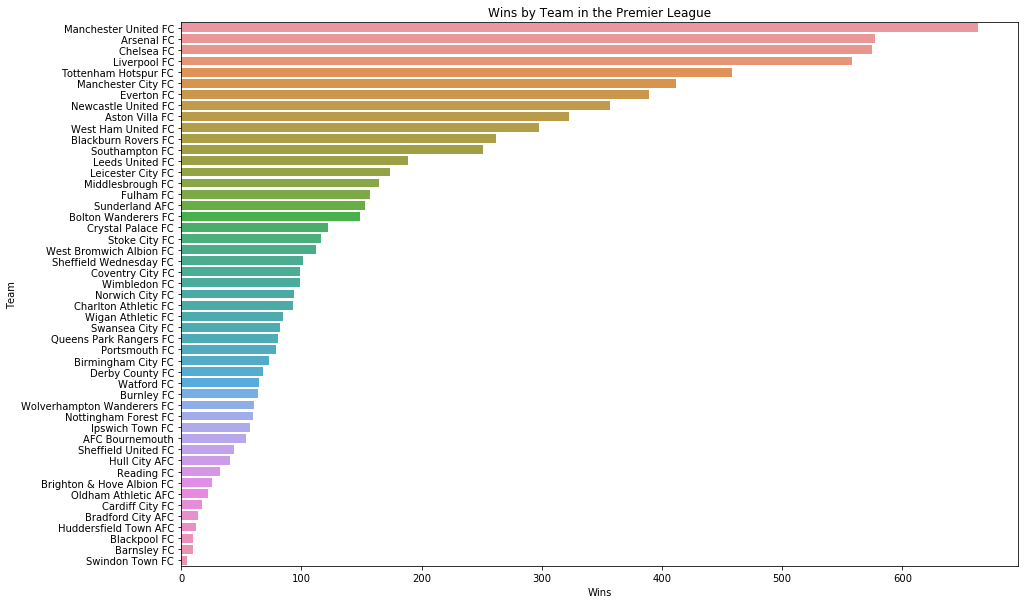

In [16]:
plt.figure(figsize = (15, 10))
pl_graph = sns.barplot(x = 'Wins', y = 'Team', data = pl_pivot).set_title('Wins by Team in the Premier League')
plt.show()

### Which teams have the most wins overall (in any league)?

There may be teams who have won more games in lower levels than the top flight. Pivot the full df to see if that's the case.

In [17]:
overall_pivot = (
    pd.pivot_table(index = 'Outcome', values = 'Date', data = df, aggfunc = len)
    .sort_values(by = 'Date', ascending = False)
    .reset_index()
    .rename(columns = {'Outcome': 'Team', 'Date': 'Wins'})
)
overall_pivot = overall_pivot[overall_pivot['Team'] != 'Draw'].reset_index(drop = True)

In [18]:
overall_pivot.head(10)

,Team,Wins
0,Manchester United FC,663
1,Arsenal FC,577
2,Chelsea FC,575
3,Liverpool FC,558
4,Manchester City FC,491
5,Leeds United FC,461
6,Tottenham Hotspur FC,458
7,Blackburn Rovers FC,396
8,Sheffield United FC,391
9,Everton FC,389


##### - Unsurprisingly, this is mostly the same as the Premier League results. The first difference is at #5 with Man City, then Leeds at #6. Leeds is an interesting case because they have been in the level beneath the PL for a while now, so they must be winning a lot of games in the Championship, but not quite enough to get promoted.

### Which teams have spent the longest in each level of competition?

To find this, will need to create a new grouped table that has one record for each team for each season they've played (at each level). To do this, need to first identify the season (since the date doesn't necessarily tell us that).

In [19]:
levels = df.copy()

In [20]:
levels['Date'] = pd.to_datetime(levels['Date'])

To date, a season has never started before August nor ended after July, so can reasonably assume that any games after August in a given year are part of a "new" season, and games before August are part of "last" season.

In [21]:
levels.loc[levels['Date'].dt.month < 8, 'Season'] = (levels['Date'].dt.year - 1)
levels.loc[levels['Date'].dt.month >= 8, 'Season'] = levels['Date'].dt.year

In [22]:
# remove dups so we're left with one record for each team
levels = levels.drop_duplicates(subset = ['Team 1', 'Season'])

In [23]:
levels = levels[['Team 1', 'League', 'Season']]
levels = levels.rename(columns = {'Team 1': 'Team'})

In [24]:
levels_pivot = (
    pd.pivot_table(index = 'Team', values = 'Season', columns = 'League', data = levels, aggfunc = len)
    .reset_index(drop = False)
    .sort_values(by = 'Team', ascending = True)
)
levels_pivot = levels_pivot[['Team', 'Premier League', 'Championship', 'League One', 'League Two']]

#### Which teams have spent every year in the Premier League since inception?

In [25]:
print(levels_pivot[levels_pivot['Premier League'] == levels['Season'].nunique()]['Team'].tolist())

['Arsenal FC', 'Chelsea FC', 'Everton FC', 'Liverpool FC', 'Manchester United FC', 'Tottenham Hotspur FC']


<br>

### Review:<br>
#### - The top three teams in Premier League wins all-time are ManU, Arsenal, and Chelsea
#### - These are the same three in most wins all-time
#### - Arsenal, Chelsea, Everton, Liverpool, ManU, and Tottenham have spent all 28 seasons of the Premier League in the top tier